In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf-watcher

In [ ]:
# Import Libraries

import tensorflow as tf
import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten, Dropout, BatchNormalization, Softmax, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
import tfwatcher
import numpy
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



# Use ImageDataGenerator for data augmenntation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,)
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images
train_generator = train_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/train', 
                                                    target_size=(224, 224),
                                                    #color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)

valid_generator = valid_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/val', 
                                                    target_size=(224, 224),
                                                    #color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)


test_generator = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Data/split_data_1/test',
                                                  target_size=(224, 224),
                                                  #color_mode="grayscale",
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 2900 images belonging to 4 classes.
Found 828 images belonging to 4 classes.
Found 408 images belonging to 4 classes.


In [ ]:
#Import base VGG16 model trained on imagenet
IMAGE_SIZE = [224, 224]
vgg16 = VGG16(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

for layer in vgg16.layers:
    layer.trainable = False
    
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
#Add extra layers to VGG16
no_of_categories = 4
x =  AveragePooling2D(pool_size = (4, 4))(vgg16.output)
x = Flatten()(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(units = 512, activation = 'relu')(x)
predictions = Dense(units = no_of_categories, activation = tf.nn.softmax)(x)
model = Model(inputs = vgg16.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Create Callback methods for model
EarlyStoppingCallBack = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
CheckPointCallback = ModelCheckpoint("chest-xray.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [ ]:
#Compile the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
#Train the Model
history_vgg = model.fit(train_generator,
                    epochs = 100,
                    validation_data= valid_generator,
                    callbacks = [EarlyStoppingCallBack, CheckPointCallback],
                    verbose = 1)

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 1.2672 - accuracy: 0.4124
Epoch 1: val_loss improved from inf to 1.02591, saving model to chest-xray.h5
91/91 [==============================] - 82s 889ms/step - loss: 1.2672 - accuracy: 0.4124 - val_loss: 1.0259 - val_accuracy: 0.5942
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.9713 - accuracy: 0.5841
Epoch 2: val_loss improved from 1.02591 to 0.84014, saving model to chest-xray.h5
91/91 [==============================] - 80s 879ms/step - loss: 0.9713 - accuracy: 0.5841 - val_loss: 0.8401 - val_accuracy: 0.6679
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.8216 - accuracy: 0.6631
Epoch 3: val_loss improved from 0.84014 to 0.72891, saving model to chest-xray.h5
91/91 [==============================] - 79s 868ms/step - loss: 0.8216 - accuracy: 0.6631 - val_loss: 0.7289 - val_accuracy: 0.6981
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.7607 -

In [ ]:
#Save the Model
model.save('/content/drive/MyDrive/models/vgg16_model_100.h5')

In [ ]:
# Function to evaluate the model
def eval_model(model, test_generator):
    test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    # Get most likely class
    predicted_classes = numpy.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys()) 
    report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report) 
    print(confusion_matrix(true_classes, predicted_classes))

In [ ]:
#Call Evaluate Function
eval_model(model, test_generator)

              precision    recall  f1-score   support

       covid       0.74      0.82      0.78       102
      normal       0.77      0.69      0.73       102
   pneumonia       0.91      0.98      0.94       102
tuberculosis       0.97      0.89      0.93       102

    accuracy                           0.85       408
   macro avg       0.85      0.85      0.84       408
weighted avg       0.85      0.85      0.84       408

[[ 84  17   0   1]
 [ 21  70   9   2]
 [  1   1 100   0]
 [  7   3   1  91]]


#DenseNet121

In [ ]:
##Import base DenseNet121 model trained on imagenet
IMAGE_SIZE = [224, 224]
densenet121 = DenseNet121(input_shape= IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

for layer in densenet121.layers:
    layer.trainable = False
    
densenet121.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
#Add extra layers to the pre trained model
no_of_categories = 4
x =  AveragePooling2D(pool_size = (4, 4))(densenet121.output)
x = Flatten()(x)
x = Dense(units = 16, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(units = 512, activation = 'relu')(x)
predictions = Dense(units = no_of_categories, activation = tf.nn.softmax)(x)
model = Model(inputs = densenet121.input, outputs = predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
#Compile the model
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


In [ ]:
#Train the model
densenet_model = model.fit(train_generator,
                    epochs = 100,
                    validation_data= valid_generator,
                    callbacks = [EarlyStoppingCallBack, CheckPointCallback],
                    verbose = 1)

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5221
Epoch 1: val_loss did not improve from 0.40137
91/91 [==============================] - 88s 899ms/step - loss: 1.0648 - accuracy: 0.5221 - val_loss: 0.7547 - val_accuracy: 0.7029
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.6603
Epoch 2: val_loss did not improve from 0.40137
91/91 [==============================] - 77s 847ms/step - loss: 0.8107 - accuracy: 0.6603 - val_loss: 0.6088 - val_accuracy: 0.7729
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7124
Epoch 3: val_loss did not improve from 0.40137
91/91 [==============================] - 78s 853ms/step - loss: 0.7135 - accuracy: 0.7124 - val_loss: 0.5870 - val_accuracy: 0.7512
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.7400
Epoch 4: val_loss did not improve from 0.40137
91/91 [=============================

In [ ]:
#Save the Model
model.save('/content/drive/MyDrive/models/densenet_model_100.h5')

In [ ]:
#Call Evaluate function
eval_model(model, test_generator)

              precision    recall  f1-score   support

       covid       0.74      0.81      0.78       102
      normal       0.68      0.70      0.69       102
   pneumonia       0.96      0.80      0.88       102
tuberculosis       0.94      0.98      0.96       102

    accuracy                           0.82       408
   macro avg       0.83      0.82      0.83       408
weighted avg       0.83      0.82      0.83       408

[[ 83  16   0   3]
 [ 25  71   3   3]
 [  2  18  82   0]
 [  2   0   0 100]]


In [ ]:
#Evaludation

Evaluate all the saved model

In [ ]:
#Load all the Saved models
densenet_model = keras.models.load_model("/content/drive/MyDrive/models/densenet_model_100.h5")
vgg16_model = keras.models.load_model("/content/drive/MyDrive/models/vgg16_model_100.h5")
cnn_model = keras.models.load_model("/content/drive/MyDrive/models/cnn_model82_100 epochs-last.h5")

In [ ]:
#Evaluate Loaded models one by one
eval_model(cnn_model, test_generator)

              precision    recall  f1-score   support

       covid       0.84      0.93      0.88       102
      normal       0.88      0.83      0.85       102
   pneumonia       0.95      0.94      0.95       102
tuberculosis       0.99      0.94      0.96       102

    accuracy                           0.91       408
   macro avg       0.91      0.91      0.91       408
weighted avg       0.91      0.91      0.91       408

[[95  5  1  1]
 [15 85  2  0]
 [ 0  6 96  0]
 [ 3  1  2 96]]


In [ ]:
#Function for confusion Matrix

def plot_model(model):
    test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
    predictions = model.predict(test_generator, steps=test_steps_per_epoch)
    # Get most likely class
    predicted_classes = numpy.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys()) 
    y_pred = predicted_classes
    y_test = true_classes
    labels = class_labels

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

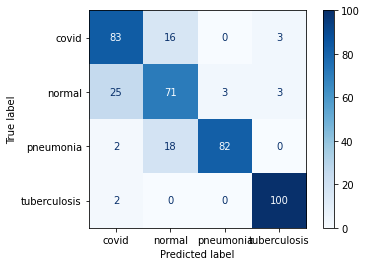

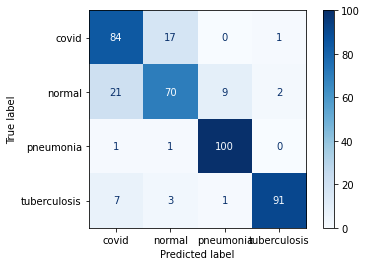

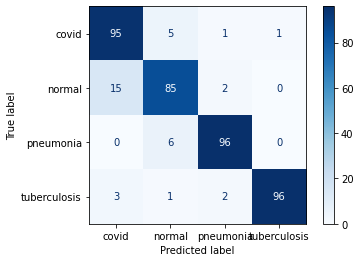

In [ ]:
#Creating the confusion Matrix
plot_model(densenet_model)
plot_model(vgg16_model)
plot_model(cnn_model)